In [1]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'Aves_reduced.ipynb',
 'New_test',
 'New_train',
 'New_valid']

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from glob import glob
from keras.models import Sequential

In [6]:
train_path = 'New_train'
test_path = 'New_test'
val_path = 'New_valid'

In [7]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.2)

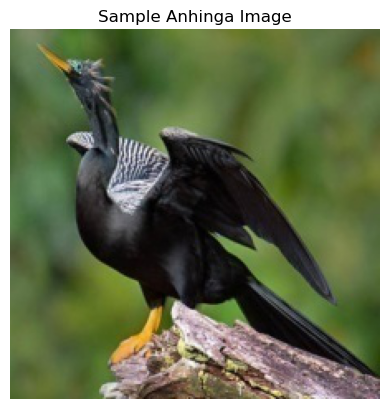

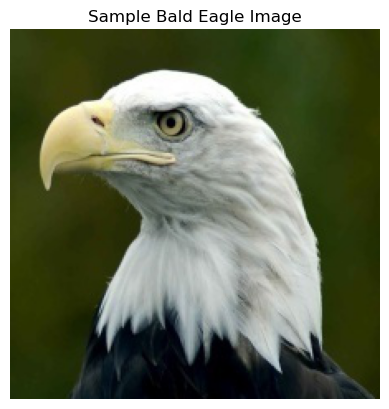

In [8]:
img = load_img(train_path + "/ANHINGA/001.jpg")
plt.imshow(img)
plt.axis("off")
plt.title("Sample Anhinga Image")
plt.show()

plt.figure()

img = load_img(train_path + "/BALD EAGLE/018.jpg")
plt.imshow(img)
plt.axis("off")
plt.title("Sample Bald Eagle Image")
plt.show()

In [9]:
className = glob(train_path + "/*")
NumberofClass = len(className)
print("Number_Of_Classes: ", NumberofClass)

Number_Of_Classes:  100


In [10]:
train_datagen = ImageDataGenerator(rescale = 1/255)
valid_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [16]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1/255,
                  shear_range=0.3,
                  horizontal_flip=True,
                  zoom_range=0.3
                  )
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                train_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

val_generator = val_datagen.flow_from_directory(
                val_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 10000 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [18]:
base_model = tf.keras.applications.InceptionV3(include_top=False)

# 2. Freezing The Base Model
base_model.trainable = False

# 3. Creating Inputs Into Our Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='InputLayer')

# 4. Passing The Inputs To The Base Model
x = base_model(inputs)

# 5. Average Pooling The Outputs Of The Base Model
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)

# 6. Creating The Output Activation Layer
outputs = tf.keras.layers.Dense(100, activation='softmax', name='OutputLayer')(x)

# 7. Combining The Inputs With The Outputs Into A Model
model_0 = tf.keras.Model(inputs, outputs)

# 8. Compiling The Model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
# 9. Fitting The Model
history_0 = model_0.fit(train_generator,
                       epochs=10,
                       steps_per_epoch=len(train_generator),
                       validation_data=val_generator,
                       validation_steps=int(0.25*len(val_generator)))

Epoch 1/10
313/313 [==============================] - 497s 2s/step - loss: 1.5166 - accuracy: 0.6282 - val_loss: 0.6538 - val_accuracy: 0.7969
Epoch 2/10
313/313 [==============================] - 471s 2s/step - loss: 0.6639 - accuracy: 0.8128 - val_loss: 0.4916 - val_accuracy: 0.8281
Epoch 3/10
313/313 [==============================] - 517s 2s/step - loss: 0.5216 - accuracy: 0.8518 - val_loss: 0.3007 - val_accuracy: 0.8672
Epoch 4/10
313/313 [==============================] - 439s 1s/step - loss: 0.4522 - accuracy: 0.8692 - val_loss: 0.3502 - val_accuracy: 0.8906
Epoch 5/10
313/313 [==============================] - 386s 1s/step - loss: 0.3743 - accuracy: 0.8918 - val_loss: 0.2480 - val_accuracy: 0.9688
Epoch 6/10
313/313 [==============================] - 387s 1s/step - loss: 0.3441 - accuracy: 0.8965 - val_loss: 0.3514 - val_accuracy: 0.8828
Epoch 7/10
313/313 [==============================] - 385s 1s/step - loss: 0.2948 - accuracy: 0.9126 - val_loss: 0.1987 - val_accuracy: 0.9609

In [19]:
# Unfreezing All Of The Layers In The Base Model
base_model.trainable = True

# Refreezing Every Layer Except The Last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [20]:
# Recompiling Model With Lower Learning Rate
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [21]:
# What Layers In The Model Are Trainable?
for layer in model_0.layers:
  print(layer.name, layer.trainable)

InputLayer True
inception_v3 True
GlobalAveragePoolingLayer True
OutputLayer True


In [22]:
initial_epochs = 5

# Fine Tuning For Another 5 Epochs
fine_tune_epochs = initial_epochs + 5

# Refitting The Model
history_data_aug_fine_tuned = model_0.fit(train_generator,
                                 epochs=fine_tune_epochs,
                                 validation_data=val_generator,
                                 validation_steps=int(0.25 * len(val_generator)),
                                 initial_epoch=history_0.epoch[-1])

Epoch 10/10
313/313 [==============================] - 398s 1s/step - loss: 0.1494 - accuracy: 0.9573 - val_loss: 0.2386 - val_accuracy: 0.9453


In [23]:
test_data = train_datagen.flow_from_directory(
                test_path,
                target_size=(224,224),
                batch_size=batch_size,
                color_mode="rgb",
                class_mode="categorical"
                )

Found 500 images belonging to 100 classes.


In [24]:
model_0.evaluate(test_data)

16/16 [==============================] - 19s 1s/step - loss: 0.2209 - accuracy: 0.9380


[0.22087758779525757, 0.9380000233650208]

In [27]:
model_name = 'Avesred.h5'
model_0.save(model_name, save_format='h5')

In [28]:
import pickle
with open('mode_pickle','wb')as f:
    pickle.dump(history_data_aug_fine_tuned,f)

INFO:tensorflow:Assets written to: ram://a9928c60-d793-45b9-8449-4992d1342aa4/assets


INFO:tensorflow:Assets written to: ram://a9928c60-d793-45b9-8449-4992d1342aa4/assets
